In [1]:
import sys
sys.path.append('../')

import tensorflow as tf

from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import lib.utils as utils
from lib.constants import S, B, C, INPUT_SIZE, CLASS_NAMES,CLASS_COLORS, LAMBDA_COORD, LAMBDA_NOOBJ
import os
import cv2
import math
import pickle

In [2]:
label_names = os.listdir('./../resources/labeled_data/labels')
print(label_names)

labels = []
for label_name in label_names:
    file = open(str('./../resources/labeled_data/labels/' + label_name), 'rb')
    label = pickle.load(file)
    file.close()
    labels.append(label)

['0.txt', '1.txt', '2.txt', '3.txt']


In [3]:
image_names = os.listdir('./../resources/labeled_data/images')
print(image_names)

images = []
for image_name in image_names:
    image = utils.loadImage(path='./../resources/labeled_data/images', name=image_name, resize=(INPUT_SIZE,INPUT_SIZE),color=False)
    images.append(image)

if len(images) != len(labels):
    sys.exit('#labels != #images')

['0.png', '1.png', '2.png', '3.png']


In [4]:
#Pc  Bx  By  Bw  Bh     C1 C2
#0   0   0   0   0      0  0

In [5]:
#only works for B=1
def get_output_tensor(label):
    shape = (S,S,5*B+C)
    out = np.zeros(shape)
    cell_size = (int)(INPUT_SIZE/S)


    for box in label:
        
        x_cell = math.floor(box['b_x']/cell_size)
        y_cell = math.floor(box['b_y']/cell_size)

        if not np.array_equal(out[x_cell][y_cell], np.zeros(5*B+C)):
            sys.exit('More then one bounding box in cell')

        y = np.zeros(5*B+C)
        y[CLASS_NAMES.index(box['c'])-C] = 1

        y[0] = 1
        y[1] = (box['b_x'] - cell_size*x_cell) / cell_size
        y[2] = (box['b_y'] - cell_size*y_cell) / cell_size
        y[3] = box['b_w'] / INPUT_SIZE
        y[4] = box['b_h'] / INPUT_SIZE

        out[x_cell][y_cell] = y
    return out

In [6]:
train_images = []
train_labels = []

for i in range(0, len(images)):
    img = images[i]/255
    out_tensor = get_output_tensor(labels[i])

    train_images.append(img)
    train_labels.append(out_tensor.flatten())
    for x in range(0,3):
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        out_tensor = np.rot90(out_tensor, k=1)

        for x_cell in range(0, len(out_tensor)):
            for y_cell in range(0, len(out_tensor[x_cell])):
                box = out_tensor[x_cell][y_cell]
                if box[0] == 1:
                    y = utils.createIndependetCopy(box)
                    y[1] = math.cos(math.pi/2)*(box[1]-0.5) - math.sin(math.pi/2)*(box[2]-0.5) + 0.5
                    y[2] = math.sin(math.pi/2)*(box[1]-0.5) + math.cos(math.pi/2)*(box[2]-0.5) + 0.5
                    y[3] = box[4]
                    y[4] = box[3]
                    out_tensor[x_cell][y_cell] = y

        train_images.append(img)
        train_labels.append(out_tensor.flatten())

train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)

print(train_images.shape)
print(train_labels.shape)

(16, 448, 448)
(16, 490)


In [7]:
def leaky_reLu(x):
    return tf.keras.activations.relu(x, alpha=0.1)

In [8]:
def createModel():    
    model = models.Sequential()

    model.add(layers.Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same', activation=leaky_reLu, input_shape=(INPUT_SIZE, INPUT_SIZE, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

    #model.add(layers.Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation=leaky_reLu))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    #model.add(layers.Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation=leaky_reLu))
    model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=leaky_reLu))
    model.add(layers.Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation=leaky_reLu)) #256
    #model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=leaky_reLu))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    #for i in range(0,4):
    #    model.add(layers.Conv2D(filters=256, kernel_size=(1, 1), padding='same', activation=leaky_reLu))
    #    model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=leaky_reLu))
    model.add(layers.Conv2D(filters=512, kernel_size=(1, 1), padding='same', activation=leaky_reLu))
    #model.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation=leaky_reLu))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    ##remove
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation=leaky_reLu))
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation=leaky_reLu))

    #for i in range(0,2):
    #    model.add(layers.Conv2D(filters=512, kernel_size=(1, 1), padding='same', activation=leaky_reLu))
    #    model.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation=leaky_reLu))
    #model.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation=leaky_reLu))
    #model.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=2, padding='same', activation=leaky_reLu))
#
    #model.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation=leaky_reLu))
    #model.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation=leaky_reLu))

    model.add(layers.Flatten())
 
    model.add(layers.Dense(4096, activation=leaky_reLu))
    model.add(layers.Dense(S*S*(5*B+C)))
    
    model.summary()
    
    return model

In [9]:
def loss(y_true, y_pred):

  #print(y_true)
  #print('--------------------------------------')
  #print(y_pred)

  y_true = tf.reshape(y_true, (-1, S, S, 5*B+C))
  y_pred = tf.reshape(y_pred, (-1, S, S, 5*B+C))

  #print(y_true)
  #print(y_pred)

  #loss = tf.square(y_true - y_pred)
  # ignore elements where BOTH y_true & y_pred < 0.1
  #mask = tf.cast(tf.logical_or(y_true < 0, 1 >= 0.1) ,tf.float32)
  #loss *= mask


  #exists_box = tf.reshape(y_true[...,0:1], (-1,S*S))

  exists_box = y_true[...,0:1]


  y_pred_obj = tf.multiply(y_pred, exists_box)

  y_pred_no_obj = tf.multiply(y_pred, tf.subtract(1, exists_box))
  y_pred_no_obj = tf.add(y_pred_no_obj, tf.multiply(tf.cast(tf.fill(((1, S, S, 5*B+C)),1), 'float32') ,exists_box))

  #print(y_true[...,1:3])

  #box loss
  box_loss1 = tf.math.reduce_sum(tf.math.squared_difference(y_true[...,1:3], y_pred_obj[...,1:3]))
  box_loss2 = tf.math.reduce_sum(tf.math.squared_difference(tf.math.sqrt(tf.math.abs(y_true[...,3:5])), tf.math.sqrt(tf.math.abs(y_pred_obj[...,3:5]))))

  box_loss = tf.math.add(box_loss1, box_loss2)

  #print(box_loss1)
  #print(box_loss2)

  #object loss
  object_loss = tf.math.reduce_sum(tf.math.squared_difference(y_true[...,0:1], y_pred_obj[...,0:1]))

  #print(object_loss)

  #no object loss
  no_object_loss = tf.math.reduce_sum(tf.math.squared_difference(y_true[...,0:1], y_pred_no_obj[...,0:1]))

  #print(no_object_loss)

  #class loss
  class_loss = tf.math.reduce_sum(tf.math.squared_difference(y_true[...,5:10], y_pred_obj[...,5:10]))

  #print(class_loss)

  loss = tf.math.add_n([tf.math.multiply(LAMBDA_COORD, box_loss), tf.math.multiply(LAMBDA_NOOBJ, no_object_loss), object_loss, class_loss])


  return loss#tf.reduce_sum(loss)# / tf.reduce_sum(mask)

In [10]:
#model = tf.keras.models.load_model('./../resources/saved_model/my_model', compile=False)

model = createModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 256)       147712    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 512)       6

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=loss,
              run_eagerly=True,
              metrics=['accuracy'])

train_labels = tf.convert_to_tensor(train_labels)

#print(train_labels)
train_images = tf.expand_dims(train_images, axis=-1)

In [58]:
history = model.fit(train_images, train_labels, batch_size=8, epochs=50, use_multiprocessing=True)

Epoch 1/50
2/2 [==============================] - 2s 904ms/step - loss: 0.0602 - accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 2s 891ms/step - loss: 0.0834 - accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 2s 891ms/step - loss: 0.0870 - accuracy: 0.1250
Epoch 4/50
2/2 [==============================] - 2s 1s/step - loss: 0.0683 - accuracy: 0.0625
Epoch 5/50
2/2 [==============================] - 3s 1s/step - loss: 0.0291 - accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 2s 975ms/step - loss: 0.0452 - accuracy: 0.0625
Epoch 7/50
2/2 [==============================] - 2s 1s/step - loss: 0.0466 - accuracy: 0.0000e+00
Epoch 8/50
2/2 [==============================] - 2s 974ms/step - loss: 0.0616 - accuracy: 0.0000e+00
Epoch 9/50
2/2 [==============================] - 2s 955ms/step - loss: 0.0469 - accuracy: 0.1250
Epoch 10/50
2/2 [==============================] - 2s 940ms/step - loss: 0.0336 - accuracy: 0.2500
Epoch 11

In [59]:
model.save('./../resources/saved_model/my_model')

INFO:tensorflow:Assets written to: ./../resources/saved_model/my_model\assets


In [60]:
#model = tf.keras.models.load_model('./../resources/saved_model/my_model')

1/1 - 1s - loss: 0.0159 - accuracy: 0.0625


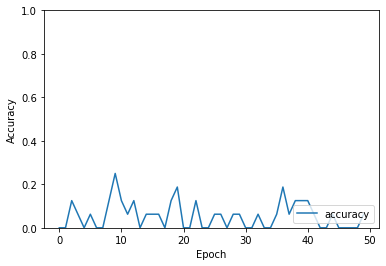

In [61]:
plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
test_loss, test_acc = model.evaluate(train_images,  train_labels, verbose=2)

In [62]:
def convertImage(image):
    for y in range(0,len(image)):
        for x in range(0, len(image[y])):
            value = (image.item(y,x,0) + image.item(y,x,1) + image.item(y,x,2)) / (image.item(y,x,0)+1)
            if value < 3.2 and value > 2.8:
                image.itemset((y,x,0),255)
                image.itemset((y,x,1),255)
                image.itemset((y,x,2),255)

    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

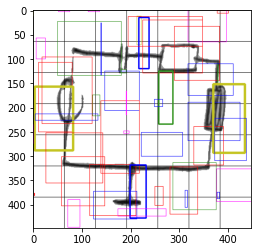

In [68]:
#img = tf.expand_dims(train_images[3], axis=0)

img = utils.loadImage('./../resources/test_images/', 'hand_test_1.png', resize=(INPUT_SIZE,INPUT_SIZE), color=True)
img = convertImage(img)
img = img/255
img = img.reshape(1, INPUT_SIZE, INPUT_SIZE, 1)

#img = np.asarray(train_images[12]).reshape(1, INPUT_SIZE, INPUT_SIZE, 1)

prediction = model.predict(img).reshape((S,S,(5*B)+C))

#prediction = np.asarray(train_labels[4]).reshape((S,S,(5*B)+C))

color_img = utils.createIndependetCopy(img*255)
color_img = color_img.reshape(INPUT_SIZE,INPUT_SIZE)
color_img = np.float32(color_img)
color_img = cv2.cvtColor(color_img, cv2.COLOR_GRAY2BGR)

color_img = np.uint8(color_img)

for x in range(0, S):
    for y in range(0, INPUT_SIZE):
        color_img[y][x*(int)(INPUT_SIZE/S)] = (0,0,0)


for y in range(0, S):
    for x in range(0, INPUT_SIZE):
        color_img[y*(int)(INPUT_SIZE/S)][x] = (0,0,0)

size = INPUT_SIZE / S

for i in range(0,7):
    for j in range(0,7):
        if prediction[i][j][0] != 0.5:
            color = CLASS_COLORS[np.argmax(prediction[i][j][-C:])]
            class_name = CLASS_NAMES[np.argmax(prediction[i][j][-C:])]

            center_x = (int)(prediction[i][j][1]*size + i*size)
            center_y = (int)(prediction[i][j][2]*size + j*size)
            width = prediction[i][j][3] * INPUT_SIZE
            height = prediction[i][j][4] * INPUT_SIZE
            #cv2.circle(color_img, ((int)(center_x),(int)(center_y)),5,color,-1)
            #cv2.putText(color_img, class_name, (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 1, color, thickness=3)
            cv2.rectangle(color_img, ((int)(center_x-width/2), (int)(center_y-height/2)), ((int)(center_x+width/2), (int)(center_y+height/2)), color, thickness=(int)(5*prediction[i][j][0]))
plt.imshow(color_img)#, cmap='gray')

In [64]:
t1 = tf.constant([[[1,2,3,4,5,6],[1,2,3,4,5,6]],[[1,2,3,4,5,6],[1,2,3,4,5,6]]])

#print(t1)

#print(t3)
t_pred = tf.constant([1,1.5,0.5,0.7,0.7,1,1,0,0,0,  0,0,0,0,0,0,0,0,0,0, 1,0.3,0.4,0.8,0.8,1,0,1,0,0,   0,0,0,0,0,0,0,0,0,0, ])
t_pred = tf.reshape(t_pred, (2,2,10))

print(t_pred)
print(t_pred[...,0:1])

tf.Tensor(
[[[1.  1.5 0.5 0.7 0.7 1.  1.  0.  0.  0. ]
  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]

 [[1.  0.3 0.4 0.8 0.8 1.  0.  1.  0.  0. ]
  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]], shape=(2, 2, 10), dtype=float32)
tf.Tensor(
[[[1.]
  [0.]]

 [[1.]
  [0.]]], shape=(2, 2, 1), dtype=float32)


In [65]:
t1 = tf.constant([[[1,2,3,4,5,6],[1,2,3,4,5,6]],[[1,2,3,4,5,6],[1,2,3,4,5,6]]])
t3 = tf.constant([1,1,1,1])
t3 = tf.cast(t3, 'float32')
#print(t3)


t_true = tf.constant([1,0.5,0.5,0.7,0.7,0,1,0,0,0,  0,0,0,0,0,0,0,0,0,0, 1,0.3,0.4,0.8,0.8,1,0,0,0,0,   0,0,0,0,0,0,0,0,0,0, ])
#t_pred = tf.constant([1,1.5,0.5,0.7,0.7,1,1,0,0,0,  1,0,0,0,0,0,1,0,0,0, 1,0.3,0.4,0.8,0.8,1,0,0,0,0,   1,0,0,0,0,1,0,0,0,0, ])

t_pred = tf.constant([1,1.5,0.5,0.7,0.7,1,1,0,0,0,  0,0,0,0,0,0,0,0,0,0, 1,0.3,0.4,0.8,0.8,1,0,1,0,0,   0,0,0,0,0,0,0,0,0,0, ])



x = custom_loss(t_true, t_pred)

print(x)

t_true = tf.reshape(t_true, (2,2,10))
t_pred = tf.reshape(t_pred, (2,2,10))


exists_box = t_true[...,0:1]

#print(tf.reshape(exists_box, 4))
#
#print(t_pred)
#print(exists_box)
#
#test = tf.multiply(t_pred, exists_box)
#
#print(test)



#t_pred = tf.map_fn(lambda x: 2*x, t_pred)

#t_pred = tf.math.multiply(t_pred, tf.constant())

#print(t_true[...,1:3])
#
#t_l = tf.math.squared_difference(t_true, t_pred)
#
#print(t_l)
#
#t_l = tf.math.reduce_sum(t_l)

#print(t_true)
#
#print(t_pred)

#print(t_l)

NameError: name 'custom_loss' is not defined